In [0]:
import torchvision
from fastai import *
from fastai.vision import *

In [0]:
def set_seed(seed=42):
    # python RNG
    import random
    random.seed(seed)

    # pytorch RNGs
    import torch
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    import numpy as np
    np.random.seed(seed)
    
set_seed()

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [0]:
def write_submission(preds, filename):
    sub = pd.read_csv('data/sample_submission_ns2btKE.csv')
    sub.category = preds
    sub.to_csv(filename, index=False)

In [0]:
def resnext50_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = torchvision.models.resnext50_32x4d(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

In [0]:
f_score = FBeta(average='weighted', beta=1)

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])

In [0]:
np.random.seed(42)
src = (ImageList.from_csv('data', 'train.csv', folder='images')
       .split_by_rand_pct(0.2, seed=42)
       .label_from_df(cols='category')
       .add_test(ImageList.from_csv('data/', csv_name='test_ApKoW4T.csv', folder='images'))
      )

In [0]:
def get_data(SZ, BS):
    data = (src.transform(tfms, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS).normalize(imagenet_stats))
    return data

def get_learner(data):
    learn = cnn_learner(data, resnext50_32x4d, pretrained=True, cut=-2,
                        split_on=lambda m: (m[0][3], m[1]), 
                        metrics=[error_rate, f_score])
    return learn

## Training with Size 128

In [0]:
data = get_data(128, 96)
learn = get_learner(data)

In [0]:
learn.mixup();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03


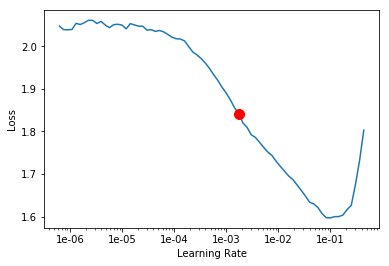

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(18, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,1.399163,0.785749,0.292000,0.700219,00:25
1,1.167915,0.641416,0.232800,0.762691,00:24
2,1.017506,0.560105,0.220800,0.772716,00:23
3,0.922721,0.471763,0.178400,0.816794,00:24
4,0.854507,0.420188,0.153600,0.847041,00:23
5,0.804291,0.395933,0.141600,0.856717,00:23
6,0.763349,0.421699,0.166400,0.824325,00:24
7,0.730965,0.316812,0.110400,0.890052,00:23
8,0.686449,0.296907,0.090400,0.909674,00:24
9,0.663478,0.308358,0.107200,0.890812,00:25


In [0]:
learn.save('ResNext50_aug_mixup_128_920192')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


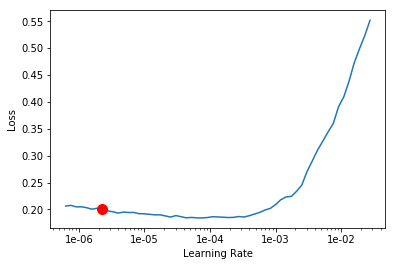

In [0]:
learn.unfreeze()
learn.clip_grad()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.load('ResNext50_aug_mixup_128_920192');
learn.unfreeze();
learn.clip_grad();

In [0]:
lr = [3e-3/100, 3e-3/20, 3e-3/10]

In [0]:
learn.fit_one_cycle(36, lr)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.187195,0.272717,0.080800,0.918603,00:31
1,0.160496,0.240827,0.076000,0.923954,00:31
2,0.126432,0.222357,0.072800,0.927303,00:31
3,0.102897,0.239679,0.079200,0.920585,00:31
4,0.083631,0.262295,0.075200,0.924491,00:30
5,0.074236,0.285108,0.081600,0.917949,00:31
6,0.080905,0.247683,0.072000,0.928409,00:30
7,0.078219,0.293685,0.081600,0.917815,00:31
8,0.070945,0.518133,0.134400,0.859231,00:31
9,0.074743,0.326079,0.088000,0.912780,00:31


In [0]:
learn.save('s2_ResNext50_aug_128_944603')

## Training with Size 256

In [0]:
data = get_data(256, 72)
learn = get_learner(data)

In [0]:
learn.load('s2_ResNext50_aug_128_944603');

In [0]:
learn.freeze();
learn.clip_grad();

In [0]:
learn.loss_func = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


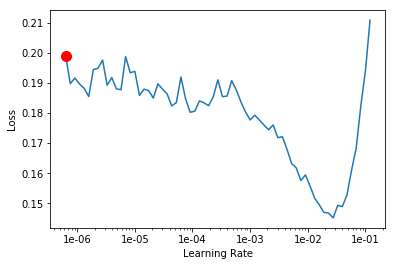

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(24, slice(3e-3))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.173847,0.342158,0.080800,0.918924,01:13
1,0.110598,0.178863,0.075200,0.924773,01:12
2,0.064229,0.108543,0.071200,0.928708,01:11
3,0.042332,0.101559,0.062400,0.937671,01:11
4,0.029126,0.092629,0.060000,0.940013,01:11
5,0.021328,0.112552,0.052000,0.948056,01:12
6,0.017713,0.088821,0.051200,0.948767,01:11
7,0.011850,0.091282,0.049600,0.950351,01:11
8,0.009709,0.110274,0.048000,0.951810,01:11
9,0.008700,0.110278,0.049600,0.950547,01:11


In [0]:
learn.save('ResNxt50_FL_128t256_962240')

In [0]:
learn.load('ResNxt50_FL_128t256_962240');

In [0]:
learn.unfreeze()
learn.clip_grad()

In [0]:
lr = [1e-3/100, 1e-3/20, 1e-3/10]
learn.fit_one_cycle(32, lr)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.006308,0.142461,0.036800,0.962972,01:43
1,0.004615,0.141906,0.037600,0.962304,01:42
2,0.003115,0.137392,0.041600,0.958198,01:42
3,0.003897,0.137139,0.048800,0.951126,01:41
4,0.003384,0.148498,0.050400,0.949666,01:42
5,0.005978,0.172913,0.048800,0.951256,01:42
6,0.003932,0.174693,0.048800,0.950974,01:41
7,0.009130,0.192829,0.056000,0.943899,01:42
8,0.012179,0.182084,0.054400,0.945714,01:41
9,0.010758,0.145602,0.047200,0.952878,01:41


In [0]:
learn.save('ResNxt50_FL_s2128t256_963172')

## Training with Size 299

In [0]:
data = get_data(299, 52)
learn = get_learner(data)

In [0]:
learn.load('ResNxt50_FL_s2128t256_963172');
learn.freeze();
learn.clip_grad();

In [0]:
learn.mixup();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


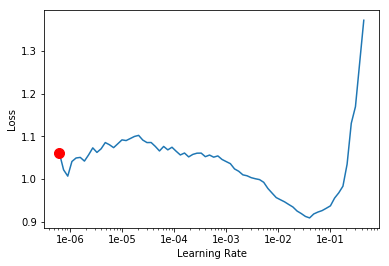

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(32, slice(2e-3))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.964833,0.154743,0.047200,0.952602,01:55
1,0.749906,0.144362,0.047200,0.952625,01:52
2,0.588627,0.190113,0.047200,0.952539,01:52
3,0.540395,0.174962,0.044000,0.955766,01:52
4,0.513541,0.170799,0.046400,0.953524,01:52
5,0.508403,0.168439,0.041600,0.958261,01:51
6,0.504746,0.178048,0.042400,0.957449,01:52
7,0.490444,0.160443,0.040000,0.959889,01:51
8,0.478344,0.151181,0.039200,0.960652,01:52
9,0.479408,0.145875,0.040800,0.959092,01:52


In [0]:
learn.save('ResNext50_FL_128t224t299_s1_965518')

In [0]:
learn.load('ResNext50_FL_128t224t299_s1_965518');

In [0]:
learn.unfreeze()
learn.clip_grad();

In [0]:
lr = [3e-3/100, 3e-3/20, 3e-3/10]
learn.fit_one_cycle(64, lr)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.429812,0.120410,0.035200,0.964752,02:28
1,0.432357,0.116121,0.032000,0.967932,02:36
2,0.417631,0.118019,0.036000,0.963939,02:37
3,0.425932,0.126109,0.036800,0.963203,02:37
4,0.426792,0.125005,0.035200,0.964770,02:37
5,0.433026,0.124370,0.036000,0.964046,02:37
6,0.433389,0.133266,0.041600,0.958332,02:37
7,0.439477,0.156730,0.044000,0.955789,02:37
8,0.425781,0.136849,0.040000,0.959962,02:37
9,0.432968,0.128504,0.042400,0.957724,02:37


In [0]:
learn.save('ResNext50_FL_s2_124t256t299_973642')

In [0]:
preds, _ = learn.get_preds(DatasetType.Test)
pred_class = torch.argmax(preds, dim=1)
pred_class += 1
pred_numpy = pred_class.numpy()

In [0]:
write_submission(pred_numpy, 'ResNet50_FL_aug_973642.csv')
#LB 0.9832088004

## Getting probabilities for Test set

In [0]:
learn.load('ResNext50_FL_s2_124t256t299_973642');

In [0]:
class_name = ['Cargo', 'Military','Carrier' ,'Cruise','Tankers']

In [0]:
predsTTA, _ = learn.TTA(ds_type=DatasetType.Test)
preds, _ = learn.get_preds(DatasetType.Test)

predTTA_df = pd.DataFrame(predsTTA.numpy(), columns=class_name)
preds_df = pd.DataFrame(preds.numpy(), columns=class_name)

preds_df.to_csv('Preds_ResNeXt50_LB_983208.csv', index=False)
predTTA_df.to_csv('TTA_ResNeXt50_LB_983208.csv', index=False)